# Raffinage des données des composés sur leurs caractéristiques ADME 
Objectif : Filtrer les molécules obtenues dans la première partie selon leurs caractéristiques physicochimiques.
## Prérequis

In [25]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
from pathlib import Path
import math

import numpy as np
import pandas as pd

import os

from pickle import load

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, MolFromSmiles

In [28]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/these_exercice/src")

In [29]:
import fct.molecularFiltering as molFilter

## Chargement des données de composés

In [30]:
# Chargement de l'identifiant uniprot de la protéine étudiée
with open("../output/01_compoundDataAcquisition/uniprot_id.txt", "rb") as file :
    uniprot_id = load(file)

# Chargement des données de composés
molecules = pd.read_csv("../output/01_compoundDataAcquisition/"+uniprot_id+"_compounds.csv")

In [31]:
print(uniprot_id)

P08581


## Ajout d'informations

In [32]:
molecules["molecular_weight"] = molecules.smiles.apply(lambda x: Descriptors.ExactMolWt(MolFromSmiles(x)))
molecules["n_hba"] = molecules.smiles.apply(lambda x: Descriptors.NumHAcceptors(MolFromSmiles(x)))
molecules["n_hbd"] = molecules.smiles.apply(lambda x: Descriptors.NumHDonors(MolFromSmiles(x)))
molecules["logp"] = molecules.smiles.apply(lambda x: Descriptors.MolLogP(MolFromSmiles(x)))

## Vérification de la conformité aux règles de Lipinksi 

In [33]:
molecules["lipinski"] = molecules.smiles.apply(molFilter.calculate_ro5_properties)

In [34]:
molecules_ro5_fulfilled = molecules[molecules["lipinski"]]
molecules_ro5_violated = molecules[~molecules["lipinski"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")

# compounds in unfiltered data set: 3204
# compounds in filtered data set: 2111
# compounds not compliant with the Ro5: 1093


In [35]:
molecules_ro5_fulfilled_stats = molFilter.calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)

In [36]:
 molecules_ro5_violated_stats = molFilter.calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)

## Radar Plot

In [42]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Mol. weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

### Composés obéissant aux règles de Lipinski

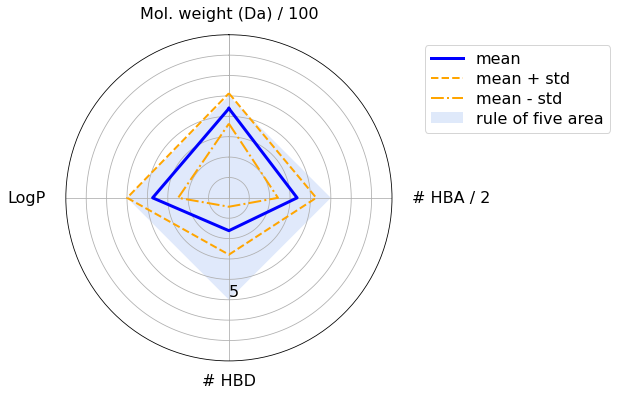

In [43]:
molFilter.plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
    output_path = "../output/02_molecularFiltering/radarPlots_ro5"
)

### Composés de respectant pas les régèles de Lipinski

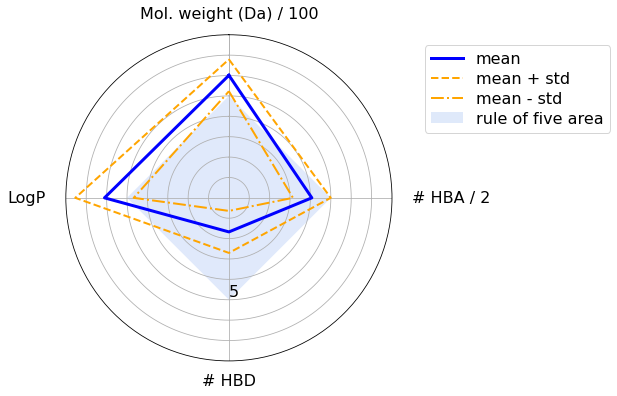

In [44]:
molFilter.plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
    output_path = "../output/02_molecularFiltering/radarPlots_nonRo5"
)

## Enregistrement des composés obéissant aux règles de Lipinksi

In [ ]:
molecules_ro5_fulfilled.to_csv("../output/02_molecularFiltering/"+uniprot_id+"_ro5Compliant.csv",
                               index=False)